In [1]:
import sys
sys.path.append('..')

from ddn_config import *
from ddn_etl_utils import *
from etl_es import *
import datetime
import hashlib

from pyspark.sql.types import BooleanType
from pyspark.sql import Row

In [2]:
start_time = '2018-07-27 19:00:00'
end_time = '2018-07-27 19:40:59'

read_label = True

In [3]:
def vpn_ip(ip):
    if '172.' in ip:
        return True
    return False
vpn_ip_udf = udf(vpn_ip, BooleanType())

In [4]:
# network_data = read_es(start_time, end_time)

In [5]:
# network_data['conn'].filter(vpn_ip_udf('`id.orig_h`'))\
#         .select('`id.orig_h`').distinct().toPandas()



In [6]:
spark = SparkSession.builder.getOrCreate()

In [7]:
node_schema = ['type', 'node_id', 'node_ip', 'node_attr', 'ddn_id']
edge_schema = ['from_id', 'to_id', 'proto', 'ddn_id', 'application', 'direction', 'total_bytes']

# the schema for matching labels with existing ddn
# category supports : 1. user; 2. application
# role: will be used as ddn id
# ids: for user, this list is ip list, for application, this list will be application key works within URI
label_schema = ['category', 'role', 'ids']

web_portal = ['192.168.7.100', '192.168.8.100']
sql_portal = ['192.168.8.74', '192.168.8.155']

#TODO: figure out an algorithm to detect multi-homed machines
multi_homed_machine = [['192.168.7.100', 
                        '192.168.8.100']]

In [20]:
multi_homed_machine_dict = {'192.168.7.100': 'web',
                            '192.168.8.100': 'web'}
rows = []
for ip in web_portal:
    row_dict = {}
    row_dict['type'] = 'application'
    row_dict['node_id'] = multi_homed_machine_dict[ip]
    row_dict['node_ip'] = ip
    row_dict['node_attr'] = ' '
    row_dict['ddn_id'] = 'default_pii'
    rows.append(Row(**row_dict))
    
rows
sc = spark.sparkContext
web_nodes = sc.parallelize(rows).toDF()
# web_nodes.collect()
# web_nodes.toDF()
# .toDF().select(node_schema)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 9.0 failed 1 times, most recent failure: Lost task 0.0 in stage 9.0 (TID 44, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pyspark/rdd.py", line 1371, in takeUpToNumLeft
    yield next(iterator)
StopIteration

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/yuming/spark-2.3.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/Users/yuming/spark-2.3.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/yuming/spark-2.3.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
RuntimeError: generator raised StopIteration

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:149)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:149)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:149)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pyspark/rdd.py", line 1371, in takeUpToNumLeft
    yield next(iterator)
StopIteration

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/yuming/spark-2.3.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/Users/yuming/spark-2.3.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/yuming/spark-2.3.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
RuntimeError: generator raised StopIteration

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:149)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:149)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [13]:
web_nodes.toPandas()

,type,node_id,node_ip,node_attr,ddn_id
0,application,web,192.168.7.100,,default_pii
1,application,web,192.168.8.100,,default_pii


In [14]:
interested_ip = web_portal + sql_portal
interested_ip
def in_list(ip):
    return ip in interested_ip
in_list_udf = udf(in_list, BooleanType())

def multihomed_ip(ip):
    for machine in multi_homed_machine:
        if ip in machine:
            return ','.join(machine)
    return None
multihomed_ip_udf = udf(multihomed_ip, StringType())

def filter_intenal_ip(ip):
    if ip is None:
        return False
    return '192.168' in ip
filter_internal_ip_udf = udf(filter_intenal_ip, BooleanType())

In [15]:
time_resolution = 300 # in secs, 5min
def float_to_datetime(seconds):
    if seconds is None:
        return 0.0
    return float(seconds)
sec_to_dt_udf = udf(float_to_datetime, DoubleType())

def ts_to_float(str):
    from dateutil.parser import parse
    if str is None:
        return 0.0
    dt = parse(str)
    return dt.timestamp()
ts_to_float_udf = udf(ts_to_float, DoubleType())
    

In [16]:
ddn = connect_ddn(start_time = start_time, 
                  end_time = end_time)
ddn = ddn.filter(col('app')!='dns')\
         .repartition(20)
from_ddn = ddn.filter(in_list_udf("`id.orig_h`"))
to_ddn = ddn.filter(in_list_udf("`id.resp_h`"))
interested_ddn = from_ddn.union(to_ddn)\
                         .withColumn('ts_float', ts_to_float_udf('@timestamp'))\
                         .persist()

GET http://192.168.7.15:9200/tds_tds7login/_search?size=10000 [status:404 request:0.004s]


Reading index tds_tds7login error from ES
Reading index fuzzy error from ES


In [17]:
interested_ddn.count()

98075

In [ ]:
connection_schema = ['`id.orig_h`', '`id.orig_p`', '`id.resp_h`', '`id.resp_p`', '@timestamp', 
                     'ts_float', 'app', 'sqlbatch', 'arg', 'cmd', 'uri', 'proto', 'method', 
                     'orig_bytes', 'resp_bytes', 'uid', 'orig_sum_bytes', 'resp_sum_bytes']
interested_ddn.distinct().count()

# this will be used to derive "edge"
all_connections = interested_ddn.select(connection_schema).distinct()

In [ ]:

# the following block calculate db host, talbes, and column names
SQL_COL = 'sql_query' # when sqlbatch works, update here
def fill_sql_query(sqlbatch, arg):
    if sqlbatch is None:
        return arg
    return sqlbatch
fill_sql_query_udf = udf(fill_sql_query, StringType())

def extract_table_column_sql(sql):
    tables = []
    columns = []
    if sql is None:
        return (tables, columns)
    sql = sql.lower()
    from_split = sql.split('from ')
    if len(from_split) == 2:
        where_split = from_split[1].split(' where ')
        tables.append(where_split[0])
        col_split = where_split[1].split(' =')
        columns.append(col_split[0])
    insert_split = sql.split('insert into ')
    if len(insert_split) == 2:
        tables.append(insert_split[1].split(' ')[0])
        columns.append('*') # all columns
    return (tables, columns)

def gen_direction(sql, method):
    if sql is not None:
        sql = sql.lower()
        if 'insert into' in sql:
            return 'co'
        if 'select' in sql:
            return 'counter'
    if method is not None:
        method = method.lower()
        if 'post' in method:
            return 'co'
        if 'get' in method:
            return 'counter'
    return None
gen_direction_udf = udf(gen_direction, StringType())

def gen_total_bytes(direction, orig_sum_bytes, resp_sum_bytes):
    if orig_sum_bytes is None:
        orig_sum_bytes = 0.0
    if resp_sum_bytes is None:
        resp_sum_bytes = 0.0
    def _my_max(a, b):
        if a >= b:
            return a
        return b
    if direction is None:
        return _my_max(orig_sum_bytes, resp_sum_bytes)
    if direction == 'co':
        return orig_sum_bytes
    return resp_sum_bytes
gen_total_bytes_udf = udf(gen_total_bytes, DoubleType())

def combine_list_to_set(x, y):
    res = set()
    res.update(x)
    res.update(y)
    return res

def process_table_col_to_row(pair):
    host = pair[0]
    table_set = pair[1][0]
    col_set = pair[1][1]
    table_list = list(table_set)
    col_list = list(col_set)
    res = {}
    res['db_host'] = host
    res['tables'] = table_list
    res['columns'] = col_list
    return Row(**res)
    
all_connections = all_connections.withColumn(SQL_COL, fill_sql_query_udf('sqlbatch', 'arg'))\
                                 .withColumn('direction', gen_direction_udf(SQL_COL, 'method'))\
                                 .withColumn('total_bytes', gen_total_bytes_udf('direction', 'orig_sum_bytes', 'resp_sum_bytes'))
db_table_col = all_connections.filter(col(SQL_COL).isNotNull())\
               .rdd.map(lambda row: (row['id.resp_h'], extract_table_column_sql(row[SQL_COL])))\
               .reduceByKey(lambda x, y: (combine_list_to_set(x[0], y[0]), combine_list_to_set(x[1], y[1])))\
               .map(lambda pair: process_table_col_to_row(pair))\
               .toDF()

In [ ]:
# Calculate db node
db_map = {
    '192.168.8.74' : 'mysql',
    '192.168.8.155': 'mssql'
    }
def generate_db_id(ip):
    return db_map[ip]
generate_db_id_udf = udf(generate_db_id, StringType())

def generate_db_ip(ip):
    return ip
generate_db_ip_udf = udf(generate_db_ip, StringType())

def generate_db_attr(columns, tables):
    res = {}
    res['columns'] = columns
    res['tables'] = tables
    return json.dumps(res)
generate_db_attr_udf = udf(generate_db_attr, StringType())

# node_schema = ['type', 'node_id', 'node_ip', 'node_attr', 'ddn_id']
db_node = db_table_col.withColumn('type', lit('database'))\
            .withColumn('node_id', generate_db_id_udf('db_host'))\
            .withColumn('node_ip', generate_db_ip_udf('db_host'))\
            .withColumn('node_attr', generate_db_attr_udf('columns', 'tables'))\
            .withColumn('ddn_id', lit('default_pii'))\
            .select(node_schema)
db_node.toPandas()
            

In [ ]:
# # the following block extracts storage node information
# db_host_list = db_table_col.select('db_host')\
#                            .rdd.map(lambda row: row[0])\
#                            .collect()
# def is_storage(ip):
#     return ip in db_host_list
# is_storage_udf = udf(is_storage, BooleanType())

# storage_to_app = all_connections.filter(is_storage_udf('`id.orig_h`'))



In [ ]:
# the following block extracts application information
application_cols = ['`id.orig_h`', '`id.orig_p`', '`id.resp_h`', '`id.resp_p`', 'application', 'proto', 'direction', 'total_bytes']

known_applications = ['payroll', 'employee_info', 'customer', 'performance', 'sales']
def extract_application_from_uri(uri):
    if uri is None \
        or uri == '/' \
        or not uri.startswith('/'):
        return 'unknown'
    for known_app in known_applications:
        if known_app in uri:
            return known_app
    tokens = uri.split('/')
    return tokens[1]
application_udf = udf(extract_application_from_uri, StringType())

def get_app_direction_from_uri(uri, direction):
    if 'set' in uri:
        return 'co'
    if 'check' in uri:
        return 'counter'
    return direction
get_app_direction_from_uri_udf = udf(get_app_direction_from_uri, StringType())

def in_web_list(ip):
    return ip in web_portal
in_web_list_udf = udf(in_web_list, BooleanType())

def in_sql_list(ip):
    return ip in sql_portal
in_sql_list_udf = udf(in_sql_list, BooleanType())

user_to_app = all_connections.filter(in_web_list_udf('`id.resp_h`'))\
                                 .withColumn('application', application_udf('uri'))\
                                 .withColumn('direction', get_app_direction_from_uri_udf('uri', 'direction'))\
                                 .select(application_cols)\
                                 .distinct().filter(col('application')!='unknown')

In [ ]:
def app_gen_from_id(from_ip, port, application):
    return from_ip + ":" + port + '/' + application
app_gen_from_id_udf = udf(app_gen_from_id, StringType())

# currently this is a placeholder
def generate_app_attr(ip):
    res = {}
    res['ip'] = ip
    return json.dumps(res)
generate_app_attr_udf = udf(generate_app_attr, StringType())

app_node = user_to_app.withColumn('type', lit('application'))\
                      .withColumn('node_id', app_gen_from_id_udf('`id.resp_h`', '`id.resp_p`', 'application'))\
                      .withColumn('node_ip', col('`id.resp_h`'))\
                      .withColumn('node_attr', generate_app_attr_udf('`id.resp_h`'))\
                      .withColumn('ddn_id', lit('default_pii'))\
                      .select(node_schema)\
                      .distinct()

In [ ]:
app_node.toPandas()

In [ ]:
# calculate app to storage edge

def app_gen_from_id(from_ip, port, application):
    return from_ip# + ":" + port + '/' + application
app_gen_from_id_udf = udf(app_gen_from_id, StringType())

def app_gen_to_id(orig_ip):
    return orig_ip
app_gen_to_id_udf = udf(app_gen_to_id, StringType())

# # this is a placeholder for application edge.
# # currently it does NOT add any information
# def app_gen_edge_attr(port, proto, total_bytes):
#     res = {}
#     res['port'] = port
#     res['protocol'] = proto
#     res['total_bytes'] = total_bytes
#     return json.dumps(res)
# app_gen_edge_attr_udf = udf(app_gen_edge_attr, StringType())

app_to_db = all_connections.filter(in_sql_list_udf('`id.resp_h`'))\
                                 .withColumn('application', application_udf('uri'))\
                                 .select(application_cols)\
                                 .distinct()
app_edge = app_to_db.withColumn('from_id', app_gen_from_id_udf('`id.orig_h`','`id.resp_p`','application'))\
                   .withColumn('to_id', app_gen_to_id_udf('`id.resp_h`'))\
                   .withColumn('ddn_id', lit('default_pii'))\
                   .select(edge_schema)\
                   .distinct()

# all_connections.filter(in_sql_list_udf('`id.resp_h`'))\
#                 .filter(in_web_list_udf('`id.orig_h`'))\
#                 .withColumn('from_id', app_gen_from_id_udf('`id.orig_h`','`id.resp_p`','application'))\
#        .withColumn('to_id', app_gen_to_id_udf('`id.resp_h`'))\
#        .withColumn('edge_attr', app_gen_edge_attr_udf('`id.resp_p`', 'proto', 'total_bytes'))\
#        .withColumn('ddn_id', lit('default_pii'))\
#        .select(edge_schema)\
#        .distinct()


In [ ]:
# the following block add user information to all the connections
# known_users = {
#     '192.168.7.130' : 'arthur',
#     '192.168.7.171' : 'hua'
# }
def add_user(ip):
    return ip
#     if ip in known_users:
#         return known_users[ip]
#     return 'unknown'
add_user_udf = udf(add_user, StringType())
all_connections_with_app = all_connections.withColumn('application', application_udf('uri'))
user_df = all_connections_with_app.withColumn('user', add_user_udf('`id.orig_h`'))\
                                  .filter(~in_list_udf('`id.orig_h`'))
#                         .filter(col('user')!='unknown')

In [ ]:
def generate_user_attr(ip, username):
    res = {}
    res['ip'] = ip
    res['username'] = username
    return json.dumps(res)
generate_user_attr_udf = udf(generate_user_attr, StringType())

user_node = user_df.withColumn('type', lit('user'))\
              .withColumn('node_id', col('user'))\
              .withColumn('node_ip', col('`id.orig_h`'))\
              .withColumn('node_attr', generate_user_attr_udf('`id.orig_h`', 'user'))\
              .withColumn('ddn_id', lit('default_pii'))\
              .select(node_schema).distinct()

In [ ]:
# node_schema = ['category', 'node_id', 'node_ip', 'node_attr', 'ddn_id']
# edge_schema = ['from_id', 'to_id', 'edge_attr', 'ddn_id']

def user_gen_from_id(orig_ip):
    return orig_ip
user_gen_from_id_udf = udf(user_gen_from_id, StringType())

def user_gen_to_id(resp_ip, port, application):
    if application is not None and application != 'unknown':
        return resp_ip + ":" + port + '/' + application
    return resp_ip
user_gen_to_id_udf = udf(user_gen_to_id, StringType())

# # this is a placeholder for user to application edge.
# # currently it does NOT add any information
# def user_gen_edge_attr(port, proto, total_bytes):
#     res = {}
#     ports = set()
#     ports.add(port)
    
#     protos = set()
#     protos.add(proto)
    
#     res['port'] = ports
#     res['protocol'] = protos
#     res['total_bytes'] = total_bytes
#     return json.dumps(res)
# user_gen_edge_attr_udf = udf(user_gen_edge_attr, StringType())

user_edge = user_df.withColumn('from_id', user_gen_from_id_udf('`id.orig_h`'))\
       .withColumn('to_id', user_gen_to_id_udf('`id.resp_h`','`id.resp_p`','application'))\
       .withColumn('ddn_id', lit('default_pii'))\
       .select(edge_schema)



In [ ]:
same_edges = nodes.filter(in_web_list_udf('node_ip'))\
     .withColumn('from_id', col('node_id'))\
     .withColumn('to_id', col('node_ip'))\
     .withColumn('direction', lit('same_machine'))\
     .withColumn('proto', lit('same_machine'))\
     .withColumn('ddn_id', lit('default_pii'))\
     .withColumn('application', lit('same_machine'))\
     .withColumn('total_bytes', lit(0)).select(edge_schema)\

In [ ]:
nodes = app_node.union(user_node).union(db_node).union(web_nodes)\
        .withColumn('multi_home', multihomed_ip_udf('node_ip'))

In [ ]:
def gen_proto(proto):
    if proto is None:
        return 'con'
    return proto
gen_proto_udf = udf(gen_proto, StringType())

In [ ]:
edges = user_edge.union(app_edge).union(same_edges)\
        .groupby('from_id', 'to_id', 'ddn_id', 'direction', 'proto')\
        .agg(sum('total_bytes').alias('total_bytes'))\
        .withColumn('proto', gen_proto_udf('proto'))


In [ ]:
edges = edges.filter(col('direction').isNotNull())
def reorder_edge(row):
    new_row = {}
    if row['direction'] == 'counter':
        new_row['from_id'] = row['to_id']
        new_row['to_id'] = row['from_id']
    else:
        new_row['from_id'] = row['from_id']
        new_row['to_id'] = row['to_id']
    new_row['proto'] = row['proto']
    new_row['total_bytes'] = row['total_bytes']
    new_row['ddn_id'] = row['ddn_id']
    return Row(**new_row)
edges_new = edges.rdd.map(reorder_edge).toDF()

In [ ]:
all_connections.filter(col('`id.resp_h`') == '192.168.7.100')\
    .filter(col('`id.orig_h`') == '172.27.232.5')\
    .toPandas()

In [ ]:
edges_new.filter(col('from_id')=='192.168.7.100').toPandas()

In [98]:
edge_from = edges_new.select('from_id').rdd.map(lambda row: row[0]).distinct().collect()
edge_to = edges_new.select('to_id').rdd.map(lambda row: row[0]).distinct().collect()
nodes_ip = nodes.select('node_ip').rdd.map(lambda row: row[0]).distinct().collect()
# nodes_id = nodes.select('node_id').rdd.map(lambda row: row[0]).distinct().collect()

In [ ]:
edges_new.filter(col('proto')=='con').show()

In [100]:
all_ip = set(edge_from + edge_to + nodes_ip)
len(all_ip)

22

In [101]:
ip_map = {}
all_ip = list(all_ip)
for i in range(0, len(all_ip)):
    ip_map[all_ip[i]] = i

def map_ip(ip, second = None):
    if second is None:
        return ip_map[ip]
    if ':80' in ip:
        return ip_map[ip]
    return ip_map[second]
map_ip_udf = udf(map_ip, IntegerType())

In [102]:
ip_map

{'172.27.232.5': 7,
 '192.168.7.100': 21,
 '192.168.7.100:80/customer': 3,
 '192.168.7.100:80/employee_info': 16,
 '192.168.7.100:80/payroll': 2,
 '192.168.7.100:80/performance': 13,
 '192.168.7.100:80/sales': 15,
 '192.168.7.104': 11,
 '192.168.7.122': 6,
 '192.168.7.126': 17,
 '192.168.7.150': 10,
 '192.168.7.159': 9,
 '192.168.7.167': 18,
 '192.168.7.171': 1,
 '192.168.7.178': 5,
 '192.168.7.180': 0,
 '192.168.7.190': 19,
 '192.168.8.100': 12,
 '192.168.8.114': 14,
 '192.168.8.155': 4,
 '192.168.8.74': 20,
 '192.168.8.74:80/PIIFormTest': 8}

In [103]:
nodes_final = nodes.withColumn('iid', map_ip_udf('node_id', 'node_ip'))
edges_final = edges_new.withColumn('iid_from', map_ip_udf('from_id'))\
                    .withColumn('iid_to', map_ip_udf('to_id'))

In [104]:
# nodes.toPandas()
nodes_final.drop('node_attr').repartition(1).write.mode('overwrite').option("header", "true").csv('nodes.csv')
edges_final.repartition(1).write.mode('overwrite').option("header", "true").csv('edges.csv')

In [117]:
edges_final.filter(col('from_id') == '192.168.7.100')\
            .filter(col('to_id') == '172.27.232.5')\
            .toPandas()

,ddn_id,from_id,proto,to_id,total_bytes,iid_from,iid_to
0,default_pii,192.168.7.100,con,172.27.232.5,0.0,21,7


In [60]:
edges_json = edges.toPandas().to_json()
nodes_json = nodes.toPandas().to_json()
ddn_dict = {}
ddn_dict['nodes'] = nodes_json
ddn_dict['edges'] = edges_json

import json
with open('ddn.json', 'w') as outfile:
    json.dump(ddn_dict, outfile)

In [25]:
# def gen_hash(from_id, to_id, ddn_id, application, direction):
#     return from_id + to_id + ddn_id + application + direction
# gen_hash_udf = udf(gen_hash, StringType())
# def combine_edge(row1, row2):
#     total_bytes1 = row1['total_bytes']
#     total_bytes2 = row2['total_bytes']
    
#     total_bytes = total_bytes1 + total_bytes2
    
#     edge_attr1 = json.loads(row1['edge_attr'])
#     edge_attr2 = json.loads(row2['edge_attr'])
    
#     new_attr = {}
#     ports = set()
#     ports.add(edge_attr1['port'])
#     ports.add(edge_attr2['port'])
    
#     protos = set()
#     protos.add(edge_attr1['protocol'])
#     protos.add(edge_attr2['protocol'])
    
#     new_attr['port'] = list(ports)
#     new_attr['protocol'] = list(protos)
#     new_attr['total_bytes'] = total_bytes
    
#     new_row = {}
#     new_row['from_id'] = row1['from_id']
#     new_row['to_id'] = row1['to_id']
#     new_row['edge_attr'] = json.dumps(new_attr)
#     new_row['ddn_id'] = row1['ddn_id']
#     new_row['direction'] = row1['direction']
#     new_row['total_bytes'] = row1['total_bytes']
#     return Row(**new_row)
# edges_combined = edges.withColumn('hash', gen_hash_udf('from_id', 'to_id', 'ddn_id', 'application', 'direction'))\
#      .rdd.map(lambda row: (row['hash'], row))\
#      .reduceByKey(combine_edge).toDF()

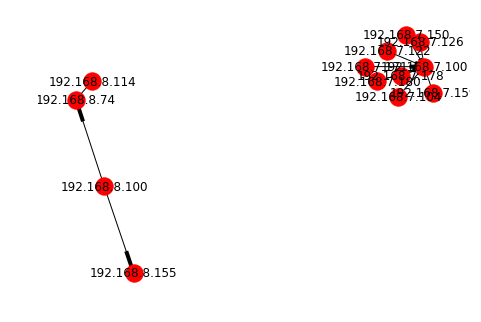

In [61]:
from_ = edges.select('from_id').rdd.map(lambda row: row[0]).collect()
to_ = edges.select('to_id').rdd.map(lambda row: row[0]).collect()

# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with 4 connections
df = pd.DataFrame({ 'from': from_, 'to': to_})
df
 
# Build your graph
G=nx.from_pandas_dataframe(df, 'from', 'to', create_using=nx.DiGraph())
 
# Plot it
nx.draw(G, with_labels=True)
plt.show()


In [269]:
from py2neo import Graph

graph = Graph("http://192.168.7.143:7474/db/data/")

# merge nodes and relationship
# create Tom and Jerry as before
u1 = Node("Person",name='Tom',id=1)
u2 = Node('Person', name='Jerry', id=2)

# either use u1 and u2 directly
u1_knows_u2 = Relationship(u1, 'KKNOWS', u2)
graph.begin()

In [278]:
def importFromCSVtoNeo(graph):
    query = "MATCH (a {id: 21}),(b {id:14}) CREATE (a)-[r:tcp]->(b) RETURN a;"
    graph.run(query)
importFromCSVtoNeo(graph)

In [141]:
# this block get label information from http request
r = requests.get('http://192.168.7.143:8000/api/label/desc/')

# Currently this is HARD CODED
if read_label:
    label_map = {}
    for labeljson in r.json():
        apps = labeljson['address'].split(',')
        label_map[labeljson['roles']] = list(apps)
    label_map
label_map

ConnectionError: HTTPConnectionPool(host='192.168.7.143', port=8000): Max retries exceeded with url: /api/label/desc/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc8cc5bc2e8>: Failed to establish a new connection: [Errno 111] Connection refused',))

In [ ]:
for new_ddn in label_map.keys():
    print(new_ddn)

In [ ]:
def label_ddn_edge_from_app(cur_ddn, application):
    for new_ddn in label_map.keys():
        app_list = label_map[new_ddn]
        if application in app_list:
            return new_ddn
    return cur_ddn
label_ddn_edge_from_app_udf = udf(label_ddn_edge_from_app, StringType())

In [ ]:
edges_labeled = edges.withColumn('ddn_id', 
                                 label_ddn_edge_from_app_udf('ddn_id', 
                                                             'application'))


In [ ]:
app_node_labeled = app_node.drop('ddn_id')\
                           .join(edges_labeled, app_node.node_id == edges_labeled.from_id, 'left_outer')\
                           .select(node_schema)
user_node_labeled = user_node.drop('ddn_id')\
                           .join(edges_labeled, user_node.node_id == edges_labeled.to_id, 'left_outer')\
                           .select(node_schema)
db_node_labeled = db_node.drop('ddn_id')\
                           .join(edges_labeled, db_node.node_id == edges_labeled.to_id, 'left_outer')\
                           .select(node_schema)

In [ ]:
node_labeled = app_node_labeled.union(user_node_labeled)\
                               .union(db_node_labeled)

In [ ]:
edges.show()